In [1]:
!pip install ucimlrepo

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt, ceil, log2
from typing import Optional

## Получение данных

In [7]:
from ucimlrepo import fetch_ucirepo

mushroom = fetch_ucirepo(id=73)

X = mushroom.data.features
Y = mushroom.data.targets

X.info()
Y.info()

Y = Y['poisonous']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                5644 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

## Обработка пустых ячеек

В stalk-root наблюдаются пустые ячейки

In [ ]:
X["stalk-root"].fillna(X["stalk-root"].mode()[0], inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                8124 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

<ipython-input-15-3d9d35447b8e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["stalk-root"].fillna(X["stalk-root"].mode()[0], inplace=True)


Пустые ячейки были заполнены модой, т.к. наиболее у нее наибольшая вероятность появления

## Визуализация данных

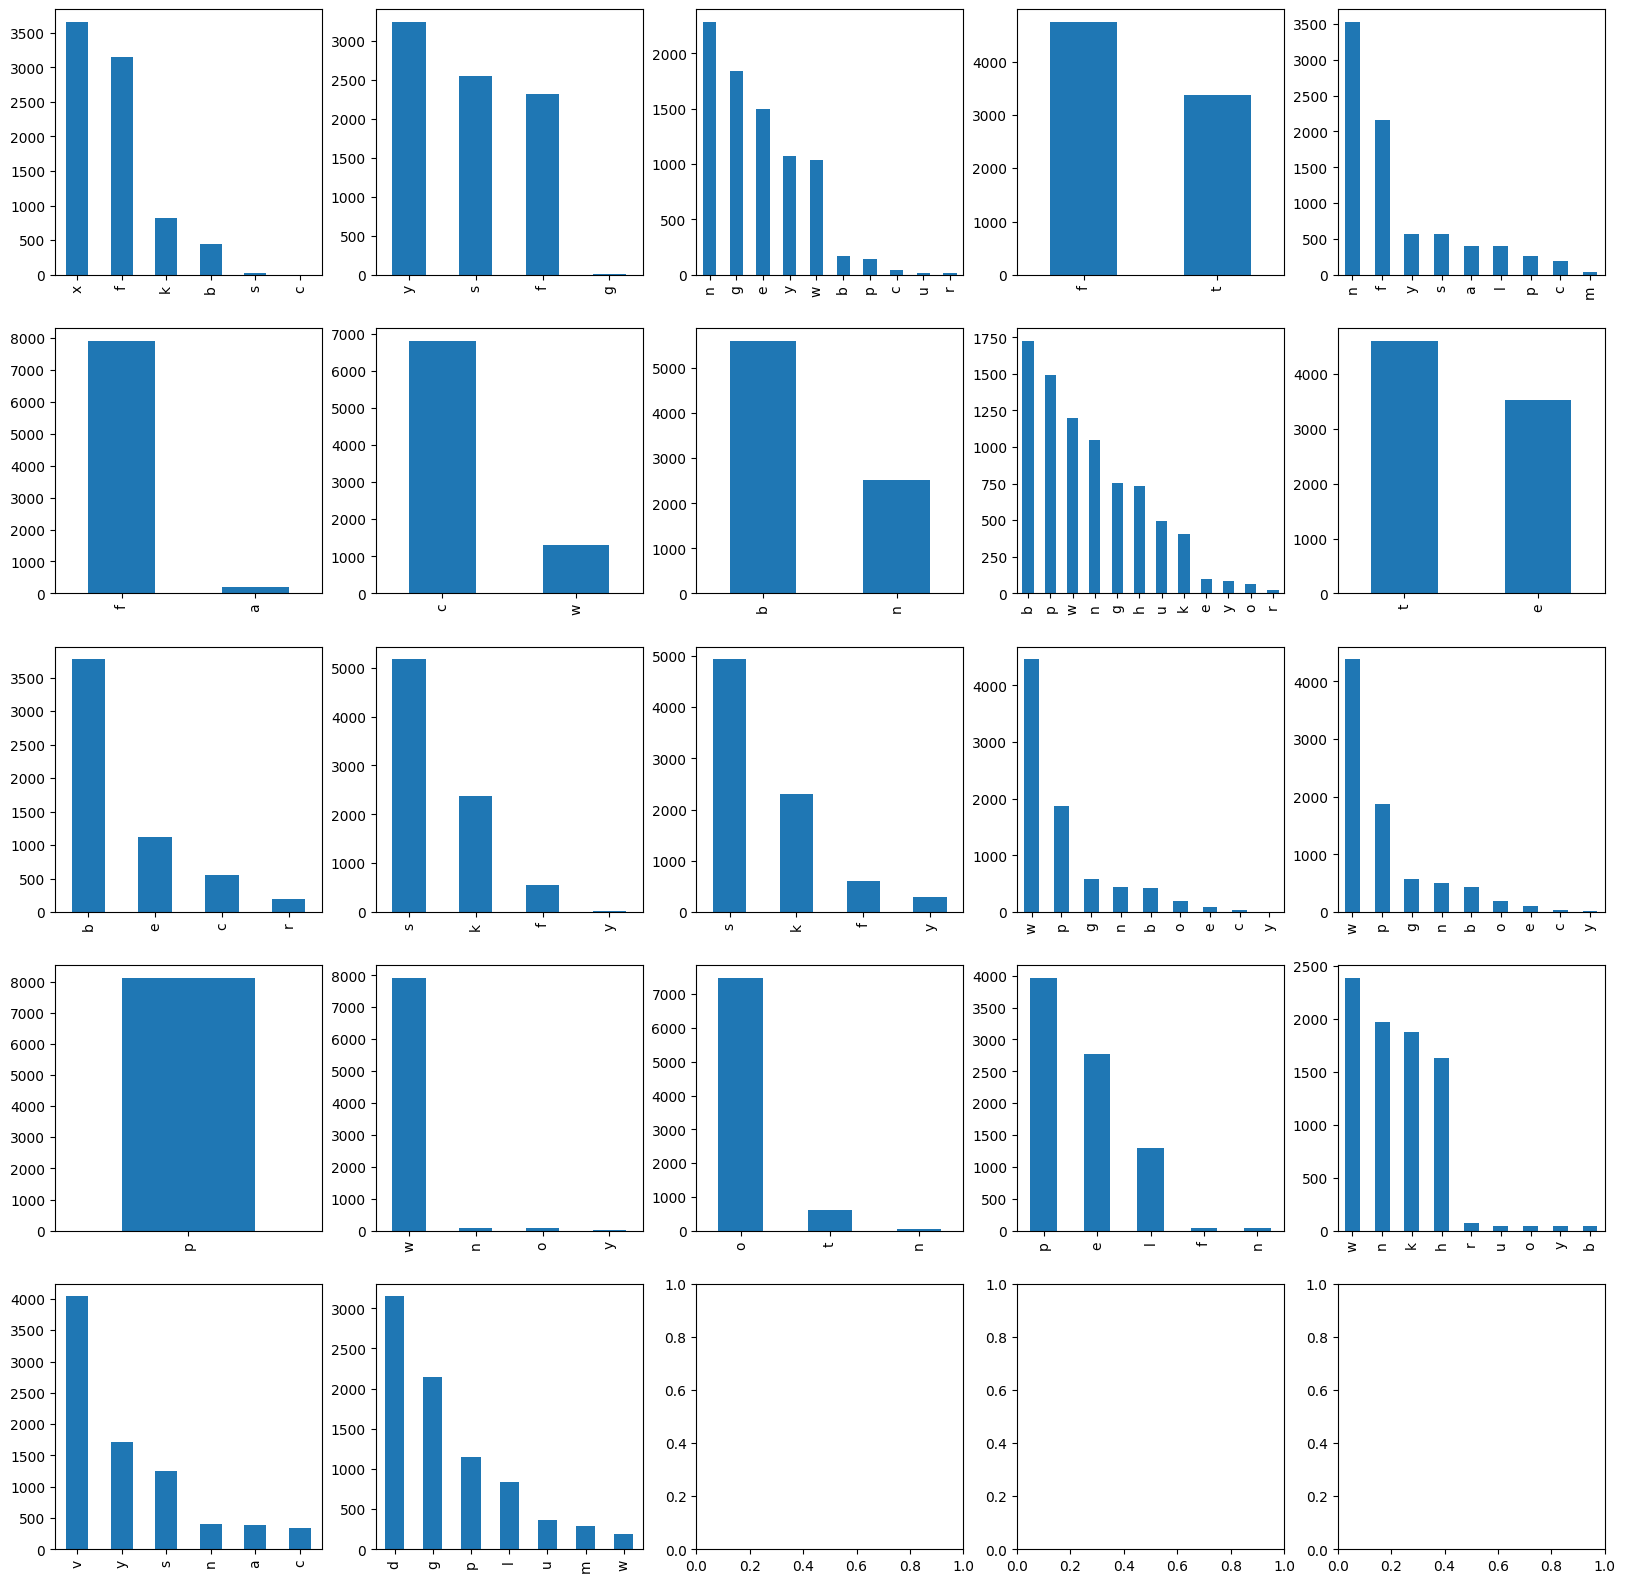

In [5]:
fig, axs = plt.subplots(ceil(sqrt(len(X.columns))), ceil(sqrt(len(X.columns))))
for ax, col in zip(axs.flatten(), X.columns): X[col].value_counts().plot(kind="bar", ax=ax)
fig.set_figheight(20)
fig.set_figwidth(20)

<Axes: >

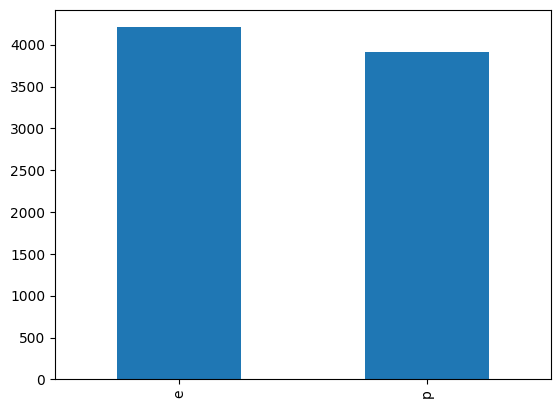

In [ ]:
Y.value_counts().plot(kind="bar")

## Дерево решений

In [32]:
class Node:
    def __init__(self,feature, value): self.feature = feature; self.value = value
    def predict(self, x): return None if x[self.feature] not in self.value else self.value[x[self.feature]].predict(x)
    def predict_probability(self, x):return 0 if x[self.feature] not in self.value else self.value[x[self.feature]].predict_probability(x)
    def print(self, spaces=0):
      for value, node in self.value.items(): print(' ' * spaces + f'Condition ({self.feature} == {value}):'); node.print(spaces + 4)

class Leaf(Node):
    def __init__(self, leaf_value, probability): super().__init__("", {}); self.leaf_value = leaf_value; self.probability = probability
    def predict(self, x): return self.leaf_value
    def predict_probability(self, x): return (self.leaf_value, self.probability)
    def print(self, indent=0): print(' ' * indent + f'Leaf ({self.leaf_value}: {self.probability})')

class DTree:
    def __init__(self, cols):self.cols = cols
    def fit(self, x, y): self.root = self.build(x[self.cols], y, DTree.entropy(y))
    def predict(self, x): return [self.root.predict(row) for row in x[self.cols].to_records()]
    def predict_probability(self, x): return [self.root.predict_probability(row) for row in x[self.cols].to_records()]
    def build(self, x, y, parent_info) -> Node:
        if len(y.unique()) == 1: return Leaf(y.unique()[0], 1)
        best_gain, best_gain_info, best_gain_col = 0, 0, ''
        for col in self.cols:
            info = 0
            for cell in x[col].unique(): info += x[col].value_counts()[cell] / len(x) * DTree.entropy(y[x[col] == cell])
            if parent_info - info > best_gain: best_gain, best_gain_info, best_gain_col = parent_info - info, info, col
        if best_gain_col == '': return Leaf(y.mode()[0], y.value_counts()[y.mode()[0]] / len(y))
        values = {}
        names = x[best_gain_col].unique()
        for n in names: values[n] = self.build(x[x[best_gain_col] == n], y[x[best_gain_col] == n], best_gain_info)
        return Node(best_gain_col, values)
    def print(self): self.root.print()
    def entropy(y):
        res = 0
        for c in y.unique(): res -= y.value_counts()[c] / len(y) * log2(y.value_counts()[c] / len(y))
        return res

## Разделение на тренировочный и тестовый наборы

In [33]:
X_test = X.sample(frac=0.3)
Y_test = Y[X_test.index]
X_train = X.drop(X_test.index, axis=0)
Y_train = Y[X_train.index]

## Обучение

In [41]:
cols = X.columns
cols = np.random.choice(cols, ceil(sqrt(len(cols))))
#cols = ['cap-color', 'stalk-color-below-ring', 'population', 'ring-type', 'stalk-shape']
print("Используются признаки:", *cols)

tree = DTree(cols)
tree.fit(X_train, Y_train)
tree.print()

Используются признаки: cap-surface stalk-color-above-ring veil-color bruises stalk-surface-below-ring
Condition (stalk-surface-below-ring == s):
    Leaf (e: 0.6957397812320092)
Condition (stalk-surface-below-ring == f):
    Condition (bruises == f):
        Leaf (e: 1)
    Condition (bruises == t):
        Leaf (p: 1)
Condition (stalk-surface-below-ring == y):
    Condition (bruises == t):
        Leaf (e: 1)
    Condition (bruises == f):
        Condition (stalk-color-above-ring == w):
            Leaf (p: 1)
        Condition (stalk-color-above-ring == c):
            Leaf (p: 1)
        Condition (stalk-color-above-ring == y):
            Leaf (p: 1)
        Condition (stalk-color-above-ring == n):
            Leaf (e: 1)
Condition (stalk-surface-below-ring == k):
    Condition (stalk-color-above-ring == n):
        Leaf (p: 1)
    Condition (stalk-color-above-ring == b):
        Leaf (p: 1)
    Condition (stalk-color-above-ring == p):
        Leaf (p: 1)
    Condition (stalk-color

## Оценка

Мы будем использовать E как положительный признак, P - как отрицательный

In [43]:
def confusion_matrix(pred_y, true_y):
    res = np.zeros((2, 2))
    for pred, true in zip(pred_y, true_y): res[1 if pred == 'e' else 0][1 if true == 'e' else 0] += 1
    return res
def confusion_matrix_prob(pred_probs, true_y, threshold):
    res = np.zeros((2, 2))
    for pred_prob, true in zip(pred_probs, true_y): res[1 if pred_prob >= threshold else 0][1 if true == 'e' else 0] += 1
    return res
def accuracy(conf): return (conf[1][1] + conf[0][0]) / sum(conf.flatten())
def precision(conf): return conf[1][1] / (conf[1][1] + conf[1][0])
def recall(conf): return conf[1][1] / (conf[1][1] + conf[0][1])
def fallout(conf): return conf[1][0] / (conf[1][0] + conf[0][0])

In [44]:
Y_pred = tree.predict(X_test)
confusion = confusion_matrix(Y_pred, Y_test)
print('Accuracy:', accuracy(confusion))
print('Precision', precision(confusion))
print('Recall:', recall(confusion))

Accuracy: 0.7800574476815757
Precision 0.714200477326969
Recall: 0.9545454545454546


## AUC

In [29]:
predict_probability = tree.predict_probability(X_test)
probabilities = []
for i in range(len(predict_probability)):
    pred, prob = predict_probability[i]
    probabilities.append(prob if pred == 'e' else 1-prob)

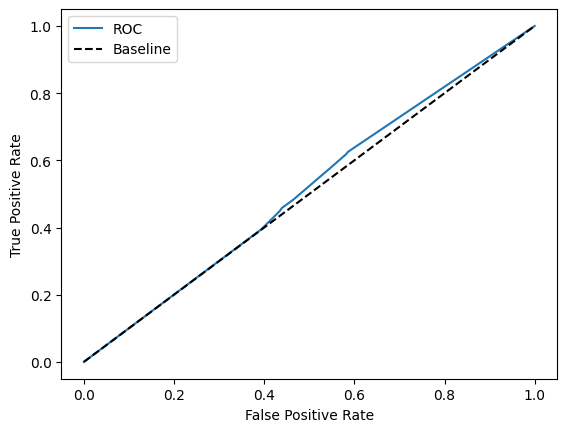

In [45]:
tpr = []
fpr = []
for th in np.arange(1, 0, -0.01):
    conf = confusion_matrix_prob(probabilities, Y_test, th)
    tpr.append(recall(conf))
    fpr.append(fallout(conf))
plt.plot([0] + fpr + [1], [0] + tpr + [1], label='ROC')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), 'k--', label='Baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

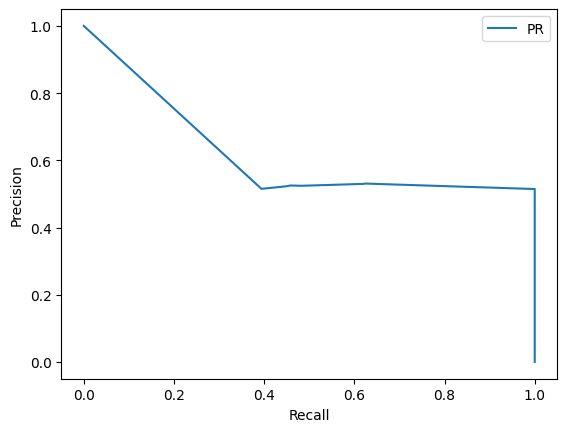

In [46]:
p = []
r = []
for th in np.arange(0, 1, 0.01):
    conf = confusion_matrix_prob(probabilities, Y_test, th)
    p.append(precision(conf))
    r.append(recall(conf))
plt.plot([1] + r + [0], [0] + p + [1], label='PR')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()